In [1]:
CACHE_DIR = "/home/anton/cache"

In [2]:
import tqdm
import time
import numpy as np

def train_eval(agent, env, train_steps, eval_steps):

    done = True
    r = None
    info = None

    ts = []
    for _ in tqdm.tqdm_notebook(range(train_steps)):
        
        start = time.time()
        
        if done:
            if r:
                agent.end_episode(r, info)
            obs = env.reset()
            a = agent.begin_episode(obs)
    #         print(a)
            obs, r, done, info = env.step(a)
    #         done = False
        else:
            a = agent.step(r, obs, info)
    #         print(a)
            obs, r, done, info = env.step(a)
        
        end = time.time()
        ts.append(end-start)
    
    mean_train_t = np.mean(ts)
    
    done = True
    r = None
    info = None
    agent.eval_mode = True
    
    ts = []
    for _ in tqdm.tqdm_notebook(range(eval_steps)):
        start = time.time()
        if done:
            if r:
                agent.end_episode(r, info)
            obs = env.reset()
            a = agent.begin_episode(obs)
            obs, r, done, info = env.step(a)
        else:
            a = agent.step(r, obs, info)
            obs, r, done, info = env.step(a)
        end = time.time()
        ts.append(end-start)
    
    mean_eval_t = np.mean(ts)
    
    return mean_train_t, mean_eval_t

In [3]:
from agents import PopularityAgent, SVDAgent, LinUCB, HLinUCB, create_drr_agent, RandomAgent

from rec_gym.wrappers import StatsWrapper, DRR_EmbBaselinesWrapper, ExplicitUserItemWrapper, DRR_ExplicitUserItemWrapper

from rec_gym.envs import MovieLensDRR

In [4]:
session_size = [10, 20, 30]
session_time = [20*60, 60*60]
normalized_reward = [True, False]

In [5]:
def make_env(session_size=10):
    env = MovieLensDRR(embedding_dimension=20, 
             n_items_to_recommend=1, 
             env_seed=0,
             normalize_reward=True,
#              filename="/home/anton/Datasets/MovieLens/ml-100k/u.data",
#              sep='\t',
             filename="/home/anton/Datasets/MovieLens/ml-1m/ratings.dat",\
             sep='::',\
#              session_time = 20 * 60,
             session_size = session_size,
             cache_dir=CACHE_DIR,
             shuffle_sessions=False)
    
    
#     env = MovieLensDRR(embedding_dimension=40, 
#              n_items_to_recommend=1, 
#              env_seed=123,
#              normalize_reward=True,
#              filename="/home/anton/Datasets/MovieLens/ml-100k/u.data",
#              sep='\t',
#     #              session_time = 20 * 60,
#              session_size = session_size,
#              cache_dir=CACHE_DIR,
#              shuffle_sessions=True
#                       )
    return StatsWrapper(env)

envs_kv = {
#     'ml-100k_s10' : lambda : make_env(10),
#     'ml-100k_s20' : lambda : make_env(20),
#     'ml-100k_s30' : lambda : make_env(30),
#       'ml-100k_s60' : lambda : make_env(60),
    'ml-1m_s30' : lambda: make_env(30)
}


agents_kv = {
    'Random' : lambda env : RandomAgent(env.unwrapped.n_rec),
    'Popularity' : lambda env: PopularityAgent(env.unwrapped),
    'SVD' : lambda env: SVDAgent(env.unwrapped),
    'LinUCB' : lambda env: LinUCB(env.unwrapped.embedding_dimension, alpha=0.2),
#     'HLinUCB' : lambda env: HLinUCB(env.unwrapped.embedding_dimension, alpha=0.2),
}

agents_drp_kv = {
    'DRPave' : lambda env: create_drr_agent(env.unwrapped, 'ave', logdir='./logs/DRPave')
}

In [6]:
from collections import defaultdict

In [7]:
results = defaultdict(dict)
results_times = defaultdict(dict)

In [8]:
for env_name, create_env in tqdm.tqdm_notebook(envs_kv.items()):
    for agent_name, create_agent_fn in tqdm.tqdm_notebook(agents_kv.items()):
        env = create_env()
        agent = create_agent_fn(env)

        mean_train_t, mean_eval_t = train_eval(agent, env, train_steps=800000, eval_steps=190000)

        results[env_name][agent_name] = env.interactions
        results_times[env_name][agent_name] = (mean_train_t, mean_eval_t)

User cache /home/anton/cache/20_s_30_0_ml-1m_ratings.dat



FileNotFoundError: [Errno 2] No such file or directory: '/home/anton/cache/20_s_30_0_ml-1m_ratings.dat/data'

In [9]:
# import tensorflow as tf
# tf.enable_eager_execution()

In [10]:
# for env_name, create_env in tqdm.tqdm_notebook(envs_kv.items()):
#     for agent_name, create_agent_fn in tqdm.tqdm_notebook(agents_drp_kv.items()):
#         env = DRR_ExplicitUserItemWrapper(create_env())
#         agent = create_agent_fn(env)

#         mean_train_t, mean_eval_t = train_eval(agent, env, train_steps=80000, eval_steps=19000)

#         results[env_name][agent_name] = env.interactions
#         results_times[env_name][agent_name] = (mean_train_t, mean_eval_t)

In [11]:
from rec_gym.wrappers import DRR_BaselinesWrapper
from stable_baselines import PPO2, DDPG, TRPO, SAC
import stable_baselines
from stable_baselines.common.vec_env import DummyVecEnv

class CustomPolicy(stable_baselines.ddpg.policies.FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 32],
                                           feature_extraction="mlp")
        
class LSTMCustomPolicy(stable_baselines.ddpg.policies.FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(LSTMCustomPolicy, self).__init__(*args, **kwargs,
                                           layers=[32, 32],
                                           feature_extraction="lstm")

class CustomPPO2Policy(stable_baselines.common.policies.FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPPO2Policy, self).__init__(*args, **kwargs,
                                           layers=[32, 32],
                                           feature_extraction="mlp")
        
class LSTMCustomPPO2Policy(stable_baselines.common.policies.FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(LSTMCustomPPO2Policy, self).__init__(*args, **kwargs,
                                           layers=[32, 32],
                                           feature_extraction="lstm")

        
class CustomPPO2Policy1(stable_baselines.common.policies.FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPPO2Policy1, self).__init__(*args, **kwargs,
                                           layers=[200, 100],
                                           feature_extraction="mlp")        
    
baseline_agents_kv = {
#      'PPO2_big' : lambda env: PPO2(CustomPPO2Policy1, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, 
#                               n_steps=64, tensorboard_log='./logs/PPO2_big'),
#     'PPO2_big_lr' : lambda env: PPO2(CustomPPO2Policy1, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, learning_rate=0.0025, 
#                               n_steps=64, tensorboard_log='./logs/PPO2_big_lr'),
#     'PPO2_lr' : lambda env: PPO2(CustomPPO2Policy, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, learning_rate=0.0025, 
#                               n_steps=64, tensorboard_log='./logs/PPO2_lr'),
#     'PPO2_s256' : lambda env: PPO2(CustomPPO2Policy, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, learning_rate=0.00025, 
#                               n_steps=256, tensorboard_log='./logs/PPO2_s256'),
#      'PPO2_s512' : lambda env: PPO2(CustomPPO2Policy, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, learning_rate=0.00025, 
#                               n_steps=512, tensorboard_log='./logs/PPO2_s512'),
#     'PPO2_s64_nopt10' : lambda env: PPO2(CustomPPO2Policy, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, learning_rate=0.00025, 
#                               n_steps=64, noptepochs=10, tensorboard_log='./logs/PPO2_s64_nopt10'),
    'DDPG' : lambda env: DDPG(CustomPolicy, DRR_BaselinesWrapper(env), 
                                      verbose=2, batch_size=64, 
                                      nb_train_steps=2,
                                      nb_eval_steps=0,
                                      nb_rollout_steps=5, 
                                      memory_limit=10000,
                                      tensorboard_log='./logs/DDPG_sb', 
                                      full_tensorboard_log=False),
#         'DDPG_256' : lambda env: DDPG(CustomPolicy, DRR_BaselinesWrapper(env), 
#                                       verbose=2, batch_size=256, 
#                                       nb_train_steps=1,
#                                       nb_eval_steps=0,
#                                       nb_rollout_steps=5, 
#                                       memory_limit=10000,
#                                       tensorboard_log='./logs/DDPG_sb', 
#                                       full_tensorboard_log=False),
    'PPO2' : lambda env: PPO2(CustomPPO2Policy, 
                              DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
                              verbose=2, 
                              n_steps=64, tensorboard_log='./logs/PPO_sb'),
#     'DDPG_lstm' : lambda env: DDPG(LSTMCustomPolicy, DRR_BaselinesWrapper(env), 
#                                       verbose=2, batch_size=64, 
#                                       nb_train_steps=1,
#                                       nb_eval_steps=0,
#                                       nb_rollout_steps=5, 
#                                       memory_limit=10000,
#                                       tensorboard_log='./logs/DDPG_sb', 
#                                       full_tensorboard_log=False),
#         'PPO2_lstm' : lambda env: PPO2(LSTMCustomPPO2Policy, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]), 
#                               verbose=2, 
#                               n_steps=64, tensorboard_log='./logs/PPO_sb'),
#     'TRPO_1024step' : lambda env: TRPO(CustomPPO2Policy, 
#                               DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]),
#                               timesteps_per_batch=1000, cg_iters=5, vf_iters=1),
#     'SAC' : lambda env: SAC( stable_baselines.sac.policies.MlpPolicy,
#                             DummyVecEnv([lambda: DRR_BaselinesWrapper(env)]),
#                             buffer_size=10000, 
#                             learning_starts=100, 
#                             train_freq=1, 
#                             batch_size=64,
#                            tensorboard_log='./logs/SAC_sb')
}

In [12]:
for env_name, create_env in tqdm.tqdm_notebook(envs_kv.items()):
    for agent_name, create_agent_fn in tqdm.tqdm_notebook(baseline_agents_kv.items()):
        print(agent_name)
        env = create_env()
        agent = create_agent_fn(env)

        agent.learn(total_timesteps=800000, log_interval=50000)
        agent.learn(total_timesteps=190000, log_interval=50000)

        results[env_name][agent_name] = env.interactions
#         results_times[env_name][agent_name] = (mean_train_t, mean_eval_t)

DDPG
User cache /home/anton/cache/20_s_30_ml-1m_ratings.dat
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/qf_output/kernel:0 <- model/qf/qf_output/kernel:0
  target/qf/qf_output/bias:0 <- model/qf/qf_output/bias:0
setting up actor optimizer
  actor shapes: [[100, 64], [64], [64, 32], [32], [32, 20], [20]]
  actor params: 9204
setting 

/home/anton/anaconda3/envs/datascience/lib/python3.7/site-packages/stable_baselines/common/mpi_adam.py:61: RuntimeWarning: invalid value encountered in sqrt
  step = (- step_size) * self.exp_avg / (np.sqrt(self.exp_avg_sq) + self.epsilon)


--------------------------------------
| reference_Q_mean        | 6.9      |
| reference_Q_std         | 2.68     |
| reference_action_mean   | 0.123    |
| reference_action_std    | 0.989    |
| reference_actor_Q_mean  | 6.93     |
| reference_actor_Q_std   | 2.68     |
| rollout/Q_mean          | 5.89     |
| rollout/actions_mean    | 0.0431   |
| rollout/actions_std     | 0.995    |
| rollout/episode_steps   | 27.7     |
| rollout/episodes        | 9.04e+03 |
| rollout/return          | 7.68     |
| rollout/return_history  | 6.24     |
| total/duration          | 1.12e+03 |
| total/episodes          | 9.04e+03 |
| total/epochs            | 1        |
| total/steps             | 249997   |
| total/steps_per_second  | 224      |
| train/loss_actor        | -6.31    |
| train/loss_critic       | 2.43     |
| train/param_noise_di... | 0        |
--------------------------------------

--------------------------------------
| reference_Q_mean        | 7.48     |
| reference_Q_std       

PPO2
User cache /home/anton/cache/20_s_30_ml-1m_ratings.dat
Instructions for updating:
Use tf.cast instead.
-------------------------------------
| approxkl           | 0.0016645968 |
| clipfrac           | 0.0078125    |
| explained_variance | 0.019        |
| fps                | 57           |
| nupdates           | 1            |
| policy_entropy     | 28.38006     |
| policy_loss        | -0.031464152 |
| serial_timesteps   | 64           |
| time_elapsed       | 6.2e-06      |
| total_timesteps    | 80           |
| value_loss         | 14.995181    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0012727139  |
| clipfrac           | 0.0078125     |
| explained_variance | 0.422         |
| fps                | 263           |
| nupdates           | 1             |
| policy_entropy     | 46.345272     |
| policy_loss        | -0.0054204054 |
| serial_timesteps   | 64            |
| time_elapsed       | 5.72e-06      |
| total_

In [13]:
# %%time
# import cloudpickle

In [14]:
# %%time
# with open('/home/anton/ml1m-offline_2.npz', 'wb') as f:
#     cloudpickle.dump(results, f)

In [21]:
def precision_at_k(recs, gt, k):
    relevant_items = set(gt[:k])
    
    rec_rel = [item in relevant_items for item in recs[:k]]
    return np.mean(rec_rel)
    
    
def precision_at_k_thresh(rewards, k, threshold=0.):
    rec_rel = [r > threshold for r in rewards[:k]]
    return np.mean(rec_rel)

def dcg_at_k(rewards, k):
    dcg = 0
    for i, r in enumerate(rewards[:k]):
        if i == 0:
            dcg += r
        else:
            dcg += 2**r - 1 / np.log2(i+1)
    return dcg

def ndcg_at_k(rewards, k):
    maxdcg = dcg_at_k(np.sort(rewards)[::-1], k)
    if maxdcg == 0: return 0
    return dcg_at_k(rewards, k) / maxdcg

In [28]:
counts = defaultdict(lambda: defaultdict(int))

for name, interactions in results['ml-1m_s30'].items():
    session_recs_by_user = defaultdict(lambda : defaultdict(list))
    session_gt_by_user = defaultdict(lambda : defaultdict(list))
    session_rewards_by_user = defaultdict(lambda : defaultdict(list))

    prev_user = None

    for i in interactions[800000:]:
        u = i.uid 
        recs = i.recs
        gt = i.raw_info['ground_truth_items']
        rewards = i.rewards

        if prev_user is None or u != prev_user:
            prev_user = u
            user_session = len(session_recs_by_user[prev_user])

        session_recs_by_user[prev_user][user_session].extend(recs)
        session_gt_by_user[prev_user][user_session].extend(gt)
        session_rewards_by_user[prev_user][user_session].extend(rewards)

    precisions = []
    precisions_thresh = []
    ndcgs = []

    for k, v in session_recs_by_user.items():
        for session_number in v:

            recs = session_recs_by_user[k][session_number][:10]

            for item in recs:
                counts[name][item] += 1
        

In [29]:
import matplotlib.pylab as plt
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values


def visualize(results):
    train_steps = 800000
    
    for K in [10, 15]:
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
        fig.suptitle('@%d' % K)
        
        
        for name, interactions in results.items():
            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[train_steps:]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)

            precisions = []
            precisions_thresh = []
            ndcgs = []

            for k, v in session_recs_by_user.items():
                for session_number in v:

                    recs = session_recs_by_user[k][session_number]
                    gt = session_gt_by_user[k][session_number]
                    rew = session_rewards_by_user[k][session_number]

                    p_at_k = precision_at_k(recs, gt, K)
                    precisions.append(p_at_k)

                    precisions_thresh.append(precision_at_k_thresh(rew, K, 0.5))

                    ndcgs.append(ndcg_at_k(np.array(rew)>=0.5, K))
            #         ndcgs.append(ndcg_at_k(np.clip(rew, 0, 1), K))
            
                    

            span = 40
            ax[0].plot(moving_average(ndcgs, span=span), 
                       label="%s : NDCG@%d = %.4f" % (name, K, np.mean(ndcgs)))
            ax[0].legend()

            ax[1].plot(moving_average(precisions, span=span), 
                       label="%s : Precision = %.4f" % (name, np.mean(precisions)) )
            ax[1].legend()

            ax[2].plot(moving_average(precisions_thresh, span=span), 
                       label='%s : Precision@%d = %.4f' % (name, K, np.mean(precisions_thresh)) )
            ax[2].legend()
    
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
        fig.suptitle('Coverage')
        xs = []
        coverages = []
        for name, interactions in results.items():
            # train
            train_items = set()

            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[:train_steps]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)

            for k, v in session_recs_by_user.items():
                for session_number in v:

                    recs = session_recs_by_user[k][session_number]

                    for item in recs:
                        train_items.add(item)

            # test
            test_items = set()

            session_recs_by_user = defaultdict(lambda : defaultdict(list))
            session_gt_by_user = defaultdict(lambda : defaultdict(list))
            session_rewards_by_user = defaultdict(lambda : defaultdict(list))

            prev_user = None

            for i in interactions[:train_steps]:
                u = i.uid 
                recs = i.recs
                gt = i.raw_info['ground_truth_items']
                rewards = i.rewards

                if prev_user is None or u != prev_user:
                    prev_user = u
                    user_session = len(session_recs_by_user[prev_user])

                session_recs_by_user[prev_user][user_session].extend(recs)
                session_gt_by_user[prev_user][user_session].extend(gt)
                session_rewards_by_user[prev_user][user_session].extend(rewards)

            for k, v in session_recs_by_user.items():
                for session_number in v:

                    recs = session_recs_by_user[k][session_number][:K]

                    for item in recs:
                        test_items.add(item)


            coverage = len(test_items & train_items) / len(train_items)

            xs.append(name)
            coverages.append(coverage)

        ax.bar(xs, coverages)

import recmetrics
def personalization(results):
    train_steps = 800000
    K = 10
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    fig.suptitle('Personalization')
    xs = []
    personalizations = []
    sessioned_recs_at_k = []
    for name, interactions in results.items():
        # test
        test_items = set()

        session_recs_by_user = defaultdict(lambda : defaultdict(list))
        session_gt_by_user = defaultdict(lambda : defaultdict(list))
        session_rewards_by_user = defaultdict(lambda : defaultdict(list))

        prev_user = None

        for i in interactions[:train_steps]:
            u = i.uid 
            recs = i.recs
            gt = i.raw_info['ground_truth_items']
            rewards = i.rewards

            if prev_user is None or u != prev_user:
                prev_user = u
                user_session = len(session_recs_by_user[prev_user])

            session_recs_by_user[prev_user][user_session].extend(recs)
            session_gt_by_user[prev_user][user_session].extend(gt)
            session_rewards_by_user[prev_user][user_session].extend(rewards)

        for k, v in session_recs_by_user.items():
            recs = session_recs_by_user[k][0][:K]
            sessioned_recs_at_k.append(recs)



        personalization = recmetrics.personalization(sessioned_recs_at_k)

        xs.append(name)
        personalizations.append(personalization)

        ax.bar(xs, personalizations)

In [30]:
import seaborn as sns
sns.set()
sns.set(font_scale=1.5) 

In [31]:
counts

defaultdict(<function __main__.<lambda>()>,
            {'Random': defaultdict(int,
                         {10: 10,
                          1285: 13,
                          597: 17,
                          26: 62,
                          9: 40,
                          798: 7,
                          982: 5,
                          1933: 2,
                          562: 15,
                          381: 45,
                          3625: 1,
                          1235: 6,
                          245: 4,
                          1120: 8,
                          262: 2,
                          2919: 2,
                          1287: 5,
                          362: 1,
                          2627: 3,
                          3684: 1,
                          8: 2,
                          2047: 12,
                          2: 5,
                          2041: 12,
                          1631: 3,
                          111: 9,
                   

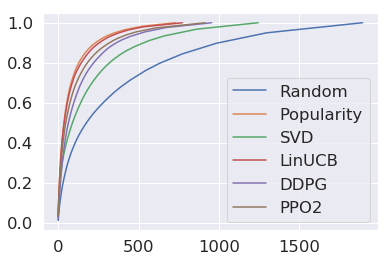

In [32]:
plt.figure()
for name, c in counts.items():
    plt.plot(np.cumsum(np.sort(list(c.values()))[::-1])/np.sum(list(c.values())), label=name)
plt.legend()
plt.show();

ml-1m_s30


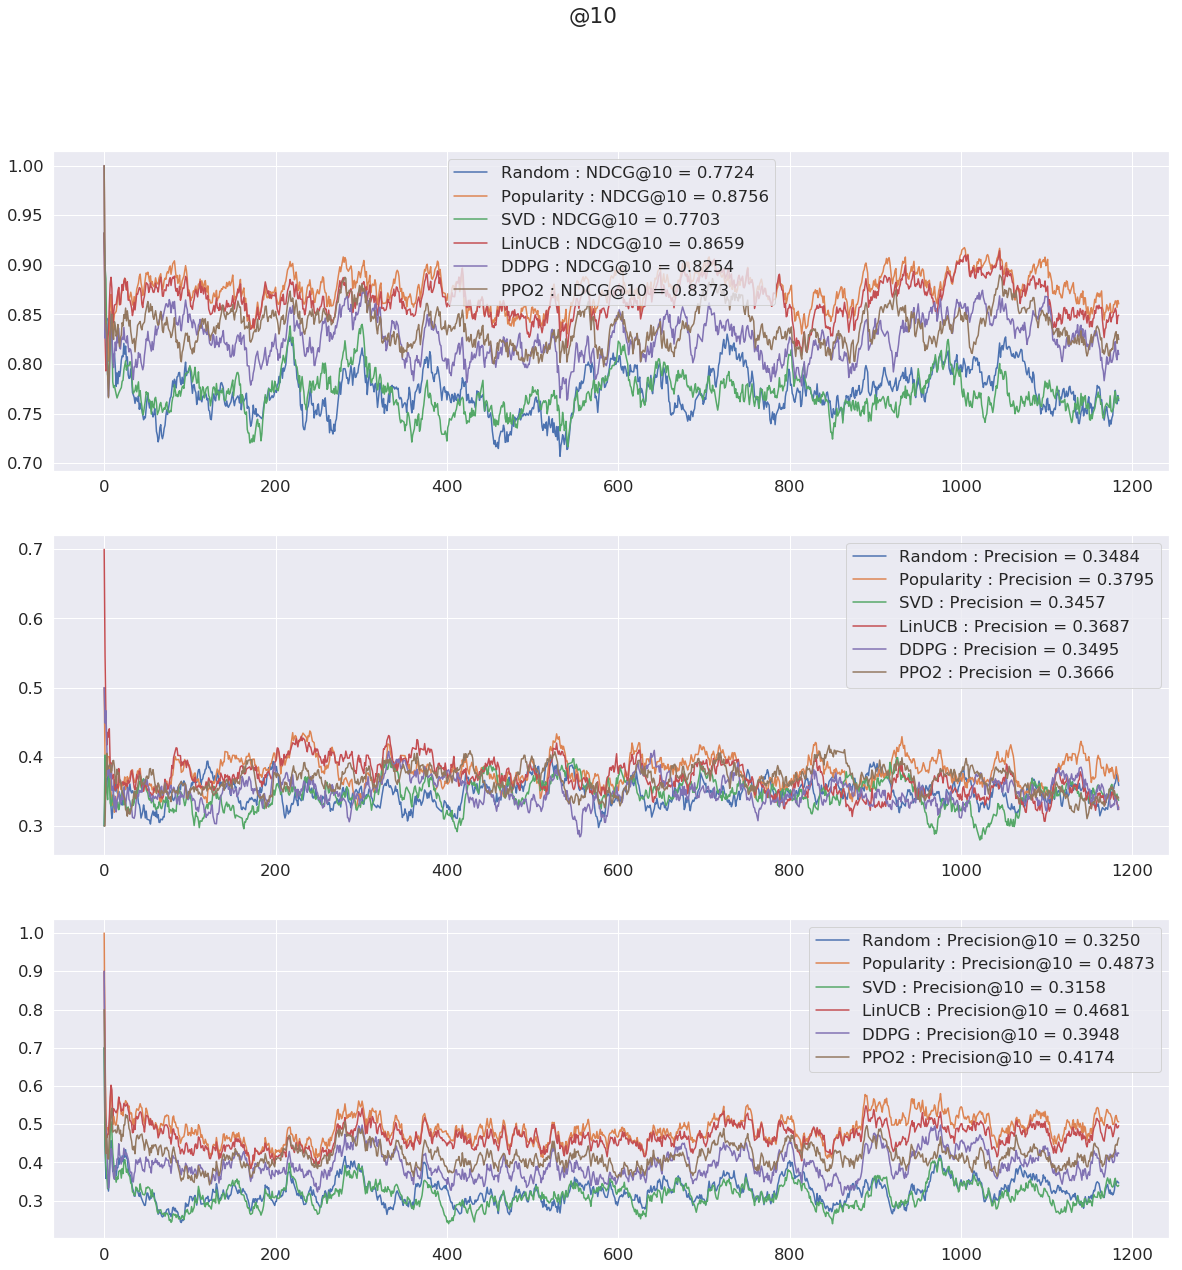

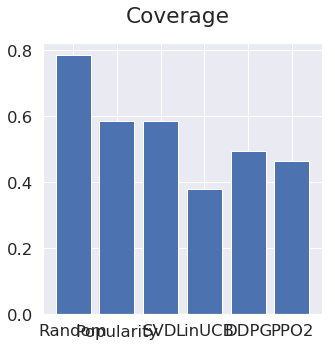

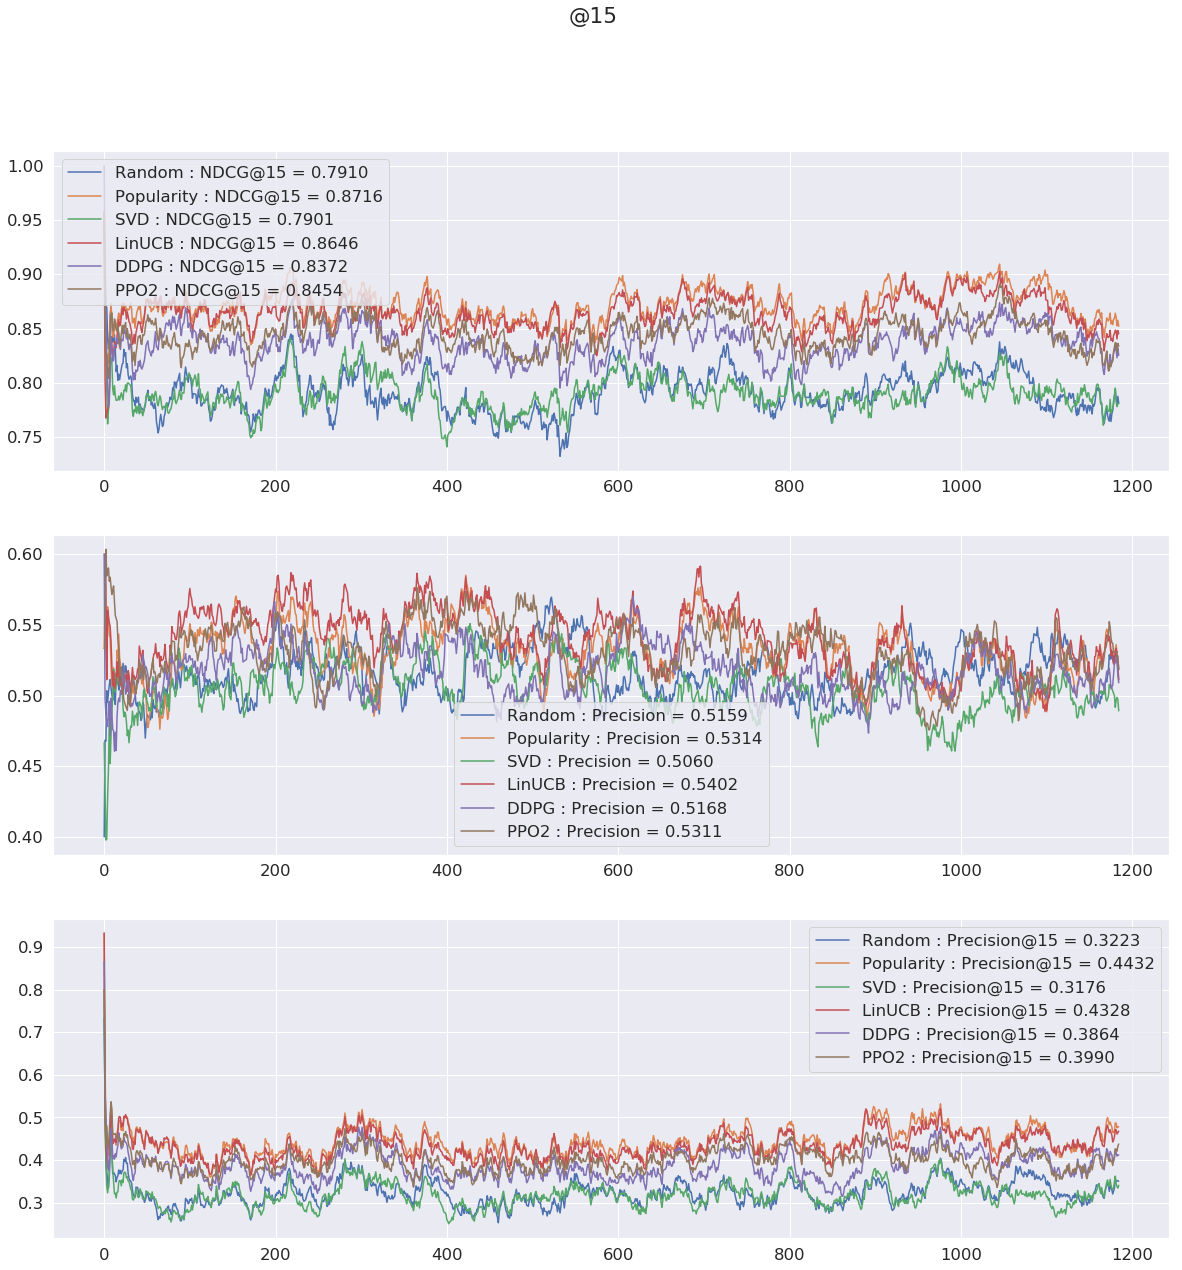

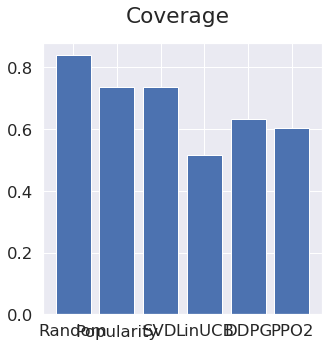

ml-1m_s20


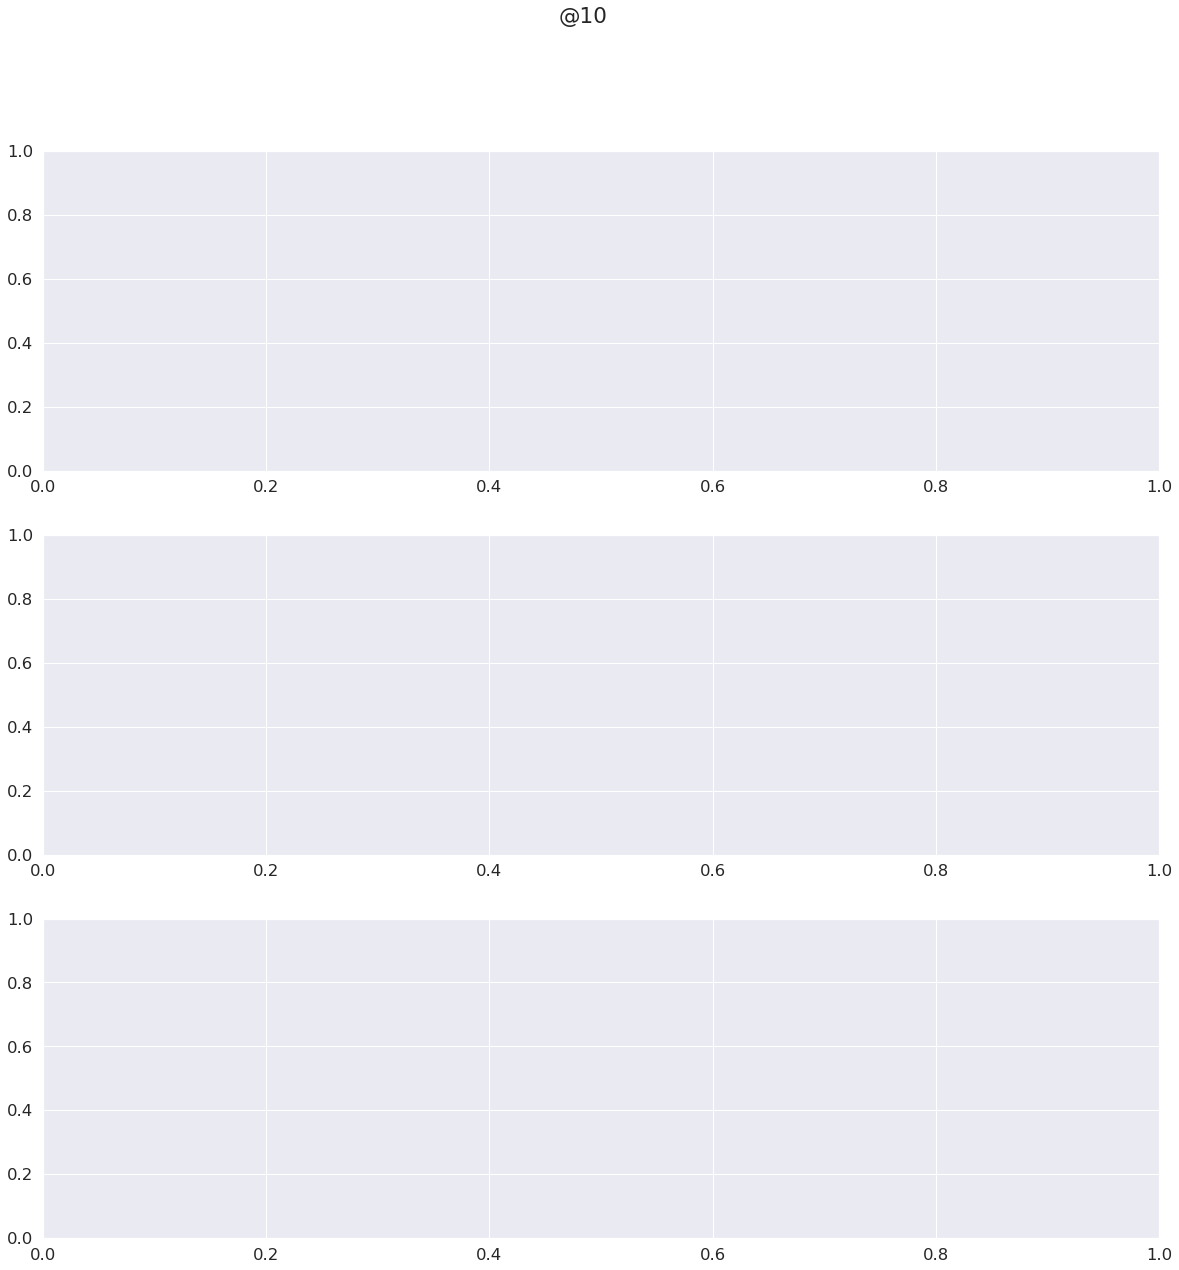

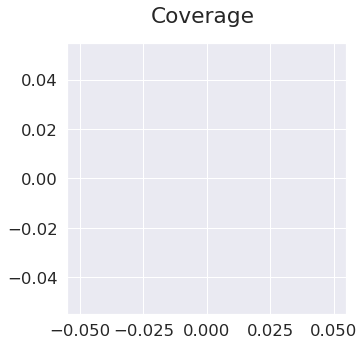

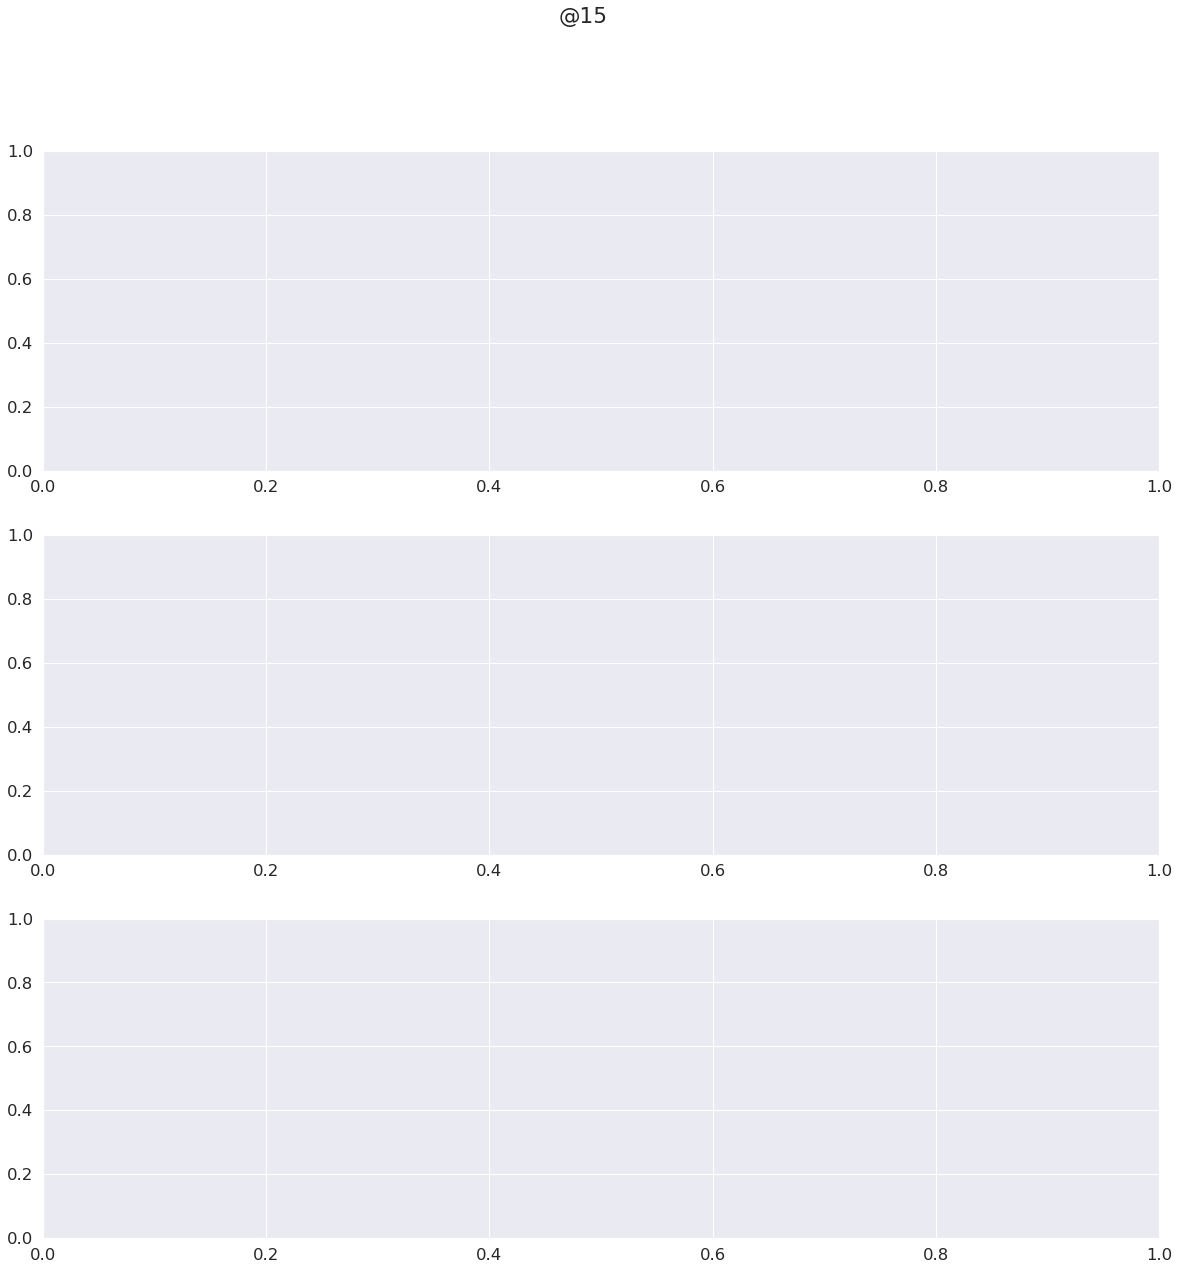

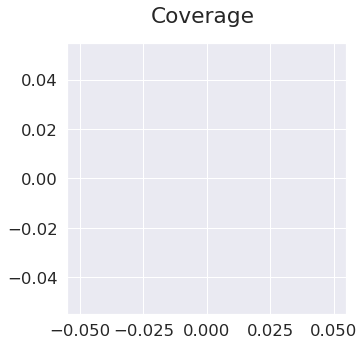

In [33]:
for env_name, res in results.items():
    print(env_name)
    visualize(res);
    plt.show();

In [ ]:
%%time
import cloudpickle
with open("results_1m.npz", "wb") as f:
    cloudpickle.dump(results, f)